In [1]:
import os
import sys
import re
import random
import math
import scipy
import numpy as np
import pandas as pd
from time import time
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.cm as cm

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import IsolationForest
from scipy import stats
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import KFold # import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline


from mpl_toolkits.mplot3d import Axes3D
cmapRdYlGn = cm.get_cmap('RdYlGn')
cmap = cm.coolwarm


challenge_data_folder = "./challenge_data"

from minisom import MiniSom

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Cleaning

In [336]:
pdAllData_Categ = pd.read_csv(challenge_data_folder+"/train.csv",keep_default_na=False) #Load training data NA filter FALSE to keep Not available data
pdTestData_Categ = pd.read_csv(challenge_data_folder+"/test.csv",keep_default_na=False)
#Categ indicates that no label encoding has been performed, the categorical features are untouched
columnTypesDict = pdAllData_Categ.dtypes.to_dict() #Infer part of the data schema
columnNames = list(columnTypesDict.keys()) #List of all features name


At a first, the only information we have on the data set resides in the description file therefore we tried to match the data and the description file to make sure the data is clean and clear. One must first match features names and then specified values in the description file and in the dataset.

In [3]:
##Data cleaning
def dataCleaning(description_file_Path):
    """Checks in the data for not mentioned values in the description file given."""
    pathDescr = (challenge_data_folder+description_file_Path)
    txtDescripData = open(pathDescr).readlines()
    columnValues={}
    columnIndex=[]
    nbHeader = 7
    NoHeaderTxtDescripData = txtDescripData[nbHeader:]
    #Parse the description file to retrieve all the lines that corresponds to features    
    for feature in columnNames:
        if feature == 'Id': continue
        for index,line in enumerate(NoHeaderTxtDescripData):
            if feature in line: #Match features name and stated name in the description
                if(line.split(feature)[0]=='' and line.split(feature)[1][0]==':' ): #Make sure exactly this feature in this line 
                    columnIndex.append((feature,index)) #We retrieved the line where the feature is described
                pass

    NoSpecificValfeatures = []
    SpecificVal = {} #Will contain as keys column names and values the specified values in the description file
    
    #Scan the cocument to retrieve specfic values for each featurz
    for index,featureLine in enumerate(columnIndex):

        startLine= featureLine[1]+2  #RTF file format 
        if index == len(columnIndex)-1: endLine = len(NoHeaderTxtDescripData)-1
        else: endLine = columnIndex[index+1][1]-1
        values = []
        if endLine <= startLine: #No specified value in the description file
            NoSpecificValfeatures.append(featureLine[0])
            continue
        for i in range(startLine,endLine):
            line = NoHeaderTxtDescripData[i] 
            values.append(line.split('\t')[0].strip())
        SpecificVal[featureLine[0]]=values #All values specified are retrieved and kept in this dictionary
        
    #Retrieve Bad values for the columns with specified values
    dicBadValues = []
    for factor in SpecificVal:

        #For a factor search for any value not specified in the description file 
        #In terms of type of valu

        typeCol = columnTypesDict[factor]
        if typeCol == 'int64': valSpec = [int(i) for i in SpecificVal[factor]]
        else: valSpec = SpecificVal[factor]
        pdInter = pdAllData_Categ.apply(lambda x: x[factor] not in valSpec,axis=1)
        potentialBadValues = pdAllData_Categ[pdAllData_Categ.apply(lambda x: x[factor] not in valSpec,axis=1)]
        nbBadVal = len(potentialBadValues)

        if nbBadVal>0:
            badValues = [factor]
            badValues.append(potentialBadValues.groupby(factor)[factor].count().to_dict())
            dicBadValues.append(badValues)
    #Retrieve Bad values for the columns with not specified values such as year of construction of 

    for feature in NoSpecificValfeatures:
        dtypeColumn = columnTypesDict[feature]
        if dtypeColumn=='float64': typeFun = float #infered type -> check if any values do not convert to this type
        elif dtypeColumn=='int64': typeFun = int
        else: typeFun=lambda x: True
        pdInter = pdAllData_Categ[pdAllData_Categ.apply(lambda x: (x[feature]=='NA') and typeFun(x[feature]) ,axis=1)]
        if len(pdInter)>0:
            badValues=[feature]
            badValues.append(pdInter.groupby(feature)[feature].count().to_dict())
            dicBadValues.append(badValues)
    return SpecificVal,NoSpecificValfeatures,dicBadValues

In [4]:
bad_description_file_Path = "/Bad_Description.rtf"
bad_specificVal,bad_noSpecificValfeatures,bad_dicBadValues = dataCleaning(bad_description_file_Path)
bad_dicBadValues

[['MSZoning', {'C (all)': 9}],
 ['Neighborhood', {'NAmes': 179}],
 ['BldgType', {'2fmCon': 28, 'Duplex': 41, 'Twnhs': 37}],
 ['Exterior2nd', {'Brk Cmn': 7, 'CmentBd': 49, 'Wd Shng': 29}],
 ['MasVnrType', {'NA': 6}],
 ['LotFrontage', {'NA': 210}],
 ['MasVnrArea', {'NA': 6}],
 ['GarageYrBlt', {'NA': 67}]]

In [5]:
description_file_Path = "/Data description.rtf"
SpecificVal,NoSpecificValfeatures,dicBadValues = dataCleaning(description_file_Path)
print(NoSpecificValfeatures)
dicBadValues

['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


[['MSZoning', {'C (all)': 9}],
 ['BldgType', {'Twnhs': 37}],
 ['MasVnrType', {'NA': 6}],
 ['LotFrontage', {'NA': 210}],
 ['MasVnrArea', {'NA': 6}],
 ['GarageYrBlt', {'NA': 67}]]

In [6]:
print('When GarageYrBlt = NA, GarageType has values ',set(pdAllData_Categ[pdAllData_Categ.apply(lambda x: x.GarageYrBlt=='NA',axis=1)].GarageType.values))
print('When MasVnrArea = NA, MasVnrArea has values',set(pdAllData_Categ[pdAllData_Categ.apply(lambda x: x.MasVnrArea=='NA',axis=1)].MasVnrType.values))

When GarageYrBlt = NA, GarageType has values  {'NA'}
When MasVnrArea = NA, MasVnrArea has values {'NA'}


In [7]:
print('When LotFrontage = NA, Alley has values ',set(pdAllData_Categ[pdAllData_Categ.apply(lambda x: x.LotFrontage=='NA',axis=1)].Alley.values))

When LotFrontage = NA, Alley has values  {'NA', 'Grvl', 'Pave'}


<div class='alert alert-warning'>
First of all, some column names were wrong in the description file erors. By deducing form the data, we changed 
Bedroom to BedroomAbvGr and 
Kitchen to KitchenAbvGr.<br>

There are also errors in the values described.<br>
Most errors with the initial description are easily corrected by slighlty modifying the description file but some are more complex and persist such as :<br>
<li>C(all)</li>
<li>Twnhs</li>
They have no direct typo or writings and the other values pecified are included in the data.<br>
Although those values are not explicit in the description file, they contain information so we decided to keep them eventhough no direct explainition of those category is available.<br>
<br>
Otherwise, the other NA values can contain information or be explained by other specified values. The two cases above state that when a property has no garage, the year the garage has been built is not available and no MasVnrType implies no MasVnrArea which is reasonable but important to take into account.<br>

To conclude on this, no purely invalid values have been spotted in the data. Plus the NA values are hard to distinguish between not measured or simply absent of the good that's why we decieded to keep them.
</div>


## Encoding Categorical Features 

In [9]:
hist = plt.hist(pdAllData_Categ.SalePrice,cumulative=True,normed=True,bins='auto')

def salePriceColor(hist,salePrice):
    index = [i for i,x in enumerate(hist[1]) if x<=salePrice][-1]
    return hist[0][max(0,index-1)]
def normHist(row):
    salePrice = row.SalePrice
    return salePriceColor(hist,salePrice)
colors = pdAllData_Categ.apply(normHist,axis=1) #Color the points in function of the sale price with a gradient guided by the cumulated histogramm
plt.clf()
plt.close()

<div class='alert alert-warning'>
        &emsp; The data may be clean, it contains unconsistent datatype; strings, int and float. However, as mentioned before, we decided to use a tree model to solve this problem and tree models give exceeding results on datasets with numerical features. Therefore the first step of our pipeline is to transform string values to numbers which is encode categorical features.<br>
        &emsp;Encoding categorical features consists in transforming discrete string values to numerical values . To do so, many techniques exists, we decided to study two approches: label encoding and one hot encoding.<br><br>
        &emsp;Label encoding consists in simply associating to a string value of a categorical feature to a int. For exemple, the Alley featurn has possible values Grvl, Pave and NA. A possible encoding would replace all Grvl values by 0, Pave values by 1 and NA values by 2. The main disadvantage of this simple technique is that it introduces an order between the numerical values that can lead to misinterpretation by the model of this feature.<br>
        &emsp;The one-hot encoding tries to cope with this problem by intoducing dummy variable. In short, for each possible values, we introduce a new column which values will be 1 where the original features had this value in the frist place 0 otherwise. In the case of the alley, we would add three column Alley_Pave, Alley_Grvl and Alley_NA. If a house has no alley then we would have 0 in Alley_Pave and Alley_Grvl and a 1 in the Alley-NA column. In the special case where the feature has only two possible values, there is no need to add a column, we simply choose one value to be 0 and the other to be 1.
</div>

In [307]:
#OLD FUNCTION

def encodeCategoricalFeatures(Data,encoding_technique='labelEncode'):
    """Encode the input dataframe Data using the label or one hot encoding technique """
    data_frames =[]
    if encoding_technique=='labelEncode': #Label Encoding technique
        lb_make = LabelEncoder() #Sklearn automatic encoder
        for featureCol in Data:
            if Data[featureCol].dtype=='object': #Categorical Feature
                data_frames.append(pd.DataFrame(lb_make.fit_transform(Data[featureCol]),columns=[featureCol]))
            else:
                data_frames.append(Data[featureCol])
    elif encoding_technique == 'persoLabelEncodeOrdered':
        for featureCol in Data:
            if Data[featureCol].dtype=='object': #Categorical Feature
                data_frames.append(labelEncodingOrdered(Data[featureCol],Data.SalePrice))
            else: 
                data_frames.append(Data[featureCol])
    elif encoding_technique =='oneHotEncode':
        for featureCol in Data:
            if Data[featureCol].dtype=='object' and featureCol in SpecificVal:
                lb_style = LabelBinarizer()
                lb_results = lb_style.fit_transform(Data[featureCol])
                if(len(lb_style.classes_)==2):columnsNames = [featureCol] #Simple binarisation -> on column resulting for two classes 
                else: columnsNames = lb_style.classes_ #One columnfor each possible values 

                lb_results = pd.DataFrame(lb_results, columns=[featureCol+"_"+name for name in columnsNames])
                data_frames.append(lb_results)
            elif Data[featureCol].dtype=='object': #NA values in a number column
                lb_make = LabelEncoder()
                data_frames.append(pd.DataFrame(lb_make.fit_transform(Data[featureCol]),columns=[featureCol]))
            else:
                data_frames.append(Data[featureCol])
    else: raise Exception('Choose an encoding technique labelEncode=True or oneHotEncode=True')
    return pd.concat(data_frames,axis=1)    
 

In [541]:
def labelEncoderWTestData(Data,DataTest):
    
    data_frames =[] #Gather encoded series to concatenate at the end
    data_frames_test =[]
    
    lb_make = LabelEncoder() #Sklearn automatic encoder
    trainAndTest_Data = pd.concat([Data,DataTest],axis=0)
    print('trainAndTest_Data shape',trainAndTest_Data.shape)
    for featureCol in trainAndTest_Data :
        if featureCol=='LotFrontage': print(trainAndTest_Data[featureCol].dtype)
        if trainAndTest_Data[featureCol].dtype=='object'and featureCol in SpecificVal: #Categorical Feature
            encode_col = pd.Series(lb_make.fit_transform(trainAndTest_Data[featureCol]))
            encode_col.name = featureCol

            data_frames.append(encode_col[:1200])
            data_frames_test.append(encode_col[1200:])
        else:
            data_frames.append(trainAndTest_Data[featureCol][:1200])
            if(featureCol!='SalePrice'):
                data_frames_test.append(trainAndTest_Data[featureCol][1200:])
    
    return data_frames, data_frames_test

In [562]:
def labelEncodingOrdered(column,columnTest,SalePrice):
    #Retrieve dictio for column train
    #print('columnName',column.name)
    colANDprice = pd.DataFrame({str(column.name): column, 'SalePrice': SalePrice})
    #print(colANDprice)
    valueDF = colANDprice.groupby(str(column.name))['SalePrice'].median().reset_index(name='median').sort_values('median').values
    #print('valueDF\n',valueDF)
    dictio = {}
    for i,valueList in enumerate(valueDF):
        dictio[valueList[0]] = i
    
    #How to replace the unknown values that are not in train?
    notInTrainValues_score = np.mean(list(dictio.values()))
    def replaceByScore(val): 
        if val not in dictio: dictio[val] = notInTrainValues_score
    notInTrainValues = columnTest.apply(replaceByScore)
    
    return column.replace(dictio), columnTest.replace(dictio), dictio

def labelEncoderOrderedWTestData(Data,DataTest):
    
    data_frames =[] #Gather encoded series to concatenate at the end
    data_frames_test =[]
    
    for featureCol in Data:
        if Data[featureCol].dtype=='object'  and featureCol in SpecificVal: #Categorical Features
            new_col, new_col_test, dictio = labelEncodingOrdered(Data[featureCol],DataTest[featureCol],Data.SalePrice)
            data_frames.append(new_col)
            data_frames_test.append(new_col_test)
        elif Data[featureCol].dtype=='object': #Continuous features with NAs
            print(featureCol)
            new_col, new_col_test, dictio = labelEncodingOrdered(Data[featureCol],DataTest[featureCol],Data.SalePrice)
            data_frames.append(new_col)
            data_frames_test.append(new_col_test)             
        else: 
            data_frames.append(Data[featureCol])
            if featureCol != 'SalePrice': data_frames_test.append(DataTest[featureCol])
    
    return data_frames, data_frames_test

In [563]:
def oneHotEncodeWTestData(Data,DataTest):
    
    data_frames =[] #Gather encoded series to concatenate at the end
    data_frames_test =[]
    
    for featureCol in Data:
        if Data[featureCol].dtype=='object' and featureCol in SpecificVal:
            lb_style = LabelBinarizer()
            lb_results = lb_style.fit_transform(Data[featureCol])
            if(len(lb_style.classes_)==2):columnsNames = [featureCol] #Simple binarisation -> on column resulting for two classes 
            else: columnsNames = lb_style.classes_ #One columnfor each possible values 

            lb_results = pd.DataFrame(lb_results, columns=[featureCol+"_"+name for name in columnsNames])
            data_frames.append(lb_results)
        elif Data[featureCol].dtype=='object': #NA values in a number column
            lb_make = LabelEncoder()
            data_frames.append(pd.DataFrame(lb_make.fit_transform(Data[featureCol]),columns=[featureCol]))
        else:
            data_frames.append(Data[featureCol])
    
    return data_frames, data_frames_test

In [564]:
def encodeCategoricalFeatures(Data,DataTest,encoding_technique='labelEncode'):
    """Encode the input dataframe Data using the label or one hot encoding technique """
    data_frames =[] #Gather encoded series to concatenate at the end
    data_frames_test =[]
    
    if encoding_technique=='labelEncode': #Label Encoding technique
        data_frames, data_frames_test = labelEncoderWTestData(Data,DataTest)
                
    elif encoding_technique == 'persoLabelEncodeOrdered':
        data_frames, data_frames_test = labelEncoderOrderedWTestData(Data,DataTest)
                    
    elif encoding_technique =='oneHotEncode':
        data_frames, data_frames_test = oneHotEncodeWTestData(Data,DataTest)
                
    else: raise Exception('Choose an encoding technique')
    
    #print([col.shape for col in data_frames_test])
    print([col.name for col in data_frames_test if col.hasnans])
    pdTestData = pd.concat(data_frames_test,axis=1)
    pdAllData = pd.concat(data_frames,axis=1)
    print([col for col in pdTestData if pdTestData[col].hasnans])
    print('pdAllData Shape ',pdAllData.shape)
    print('pdTestData Shape ',pdTestData.shape)
    return pdAllData,pdTestData
 

In [565]:
pdAllData,pdTestData = encodeCategoricalFeatures(pdAllData_Categ,pdTestData_Categ,encoding_technique='persoLabelEncodeOrdered')

LotFrontage
MasVnrArea
GarageYrBlt
[]
[]
pdAllData Shape  (1200, 81)
pdTestData Shape  (260, 80)


In [25]:
pdAllData_oneHot.head()

,Id,MSSubClass,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotFrontage,LotArea,Street_Street,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,1,60,0,0,0,1,0,71,8450,1,...,0,0,1,0,0,0,0,1,0,208500
1,2,20,0,0,0,1,0,86,9600,1,...,0,0,1,0,0,0,0,1,0,181500
2,3,60,0,0,0,1,0,74,11250,1,...,0,0,1,0,0,0,0,1,0,223500
3,4,70,0,0,0,1,0,66,9550,1,...,0,0,1,1,0,0,0,0,0,140000
4,5,60,0,0,0,1,0,90,14260,1,...,0,0,1,0,0,0,0,1,0,250000


In [ ]:
def preprocessing(pdAllData_Categ,pdTestData_Categ,scaling=True,encoding_technique='labelEncode'):
    #Encoding
    pdAllData,pdTestData = encodeCategoricalFeatures(pdAllData_Categ,encoding_technique)

    X = pdAllData.drop(['Id','SalePrice'],axis=1)
    Y = pdAllData.SalePrice
    X_test = pdTestData.drop(['Id'],axis=1)
    #Scaling 
    kept_columnValues = list(X.columns.values)
    X_scaled_array = StandardScaler().fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled_array,columns=kept_columnValues)
    return X_scaled

In [514]:
def preprocessing(pdAllData_Categ,pdTestData_Categ,scaling=True,encoding_technique='labelEncode'):
    #Encoding
    pdAllData,pdTestData = encodeCategoricalFeatures(pdAllData_Categ,pdTestData_Categ,encoding_technique)
    print(pdTestData.dtypes)
    X = pdAllData.drop(['Id','SalePrice'],axis=1)
    Y = pdAllData.SalePrice
    X_test = pdTestData.drop(['Id'],axis=1)
    
    print(X.shape,X_test.shape)
    allX = pd.concat([X,X_test],axis=0)
    #Scaling 
    kept_columnValues = list(X.columns.values)
    X_scaled_array = StandardScaler().fit_transform(allX)
    X_scaled = pd.DataFrame(X_scaled_array,columns=kept_columnValues)
    return X_scaled.iloc[range(1200)],X_scaled.iloc[range(1200,len(allX))]

In [515]:
X_scaled,X_scaled_Test = preprocessing(pdAllData_Categ,pdTestData_Categ,encoding_technique='persoLabelEncodeOrdered')

[]
[]
pdAllData Shape  (1200, 81)
pdTestData Shape  (260, 80)
Id                int64
MSSubClass        int64
MSZoning          int64
LotFrontage      object
LotArea           int64
Street            int64
Alley             int64
LotShape          int64
LandContour       int64
Utilities         int64
LotConfig         int64
LandSlope         int64
Neighborhood      int64
Condition1        int64
Condition2       object
BldgType          int64
HouseStyle        int64
OverallQual       int64
OverallCond       int64
YearBuilt         int64
YearRemodAdd      int64
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType        int64
MasVnrArea       object
ExterQual         int64
ExterCond         int64
Foundation        int64
                  ...  
HalfBath          int64
BedroomAbvGr      int64
KitchenAbvGr      int64
KitchenQual       int64
TotRmsAbvGrd      int64
Functional        int64
Fireplaces        int64
FireplaceQu       int64
Ga

ValueError: could not convert string to float: 'TenC'

## Outlier Detection

In [268]:
outliers_fraction = 0.05

def findOutliers_IsolationForest(outlierDetectionData, X, Y,outliers_fraction):
    clf = IsolationForest(max_samples=len(outlierDetectionData), contamination=outliers_fraction, random_state=42)
    clf.fit(outlierDetectionData)
    scores_pred = clf.decision_function(outlierDetectionData)
    y_pred = clf.predict(outlierDetectionData)
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
    outliers_index = np.where(y_pred==-1)[0]
    X_inlier, Y_inlier = X.drop(outliers_index,axis=0),Y.drop(outliers_index,axis=0)
    X_outlier, Y_outlier = X.filter(outliers_index,axis=0),Y.filter(outliers_index,axis=0)
    return scores_pred, y_pred, threshold, X_inlier, Y_inlier, X_outlier, Y_outlier

In [27]:
def plotOutliers(scores_pred, y_pred, threshold, X_inlier, Y_inlier, X_outlier, Y_outlier):
    plt.figure(figsize=(16,10))
    plt.subplot(321)
    scores_pred_sorted = np.sort(scores_pred)
    plt.plot([0,1199],[threshold]*2,'--',c='red')
    plt.plot(scores_pred_sorted),plt.xlabel("sample"),plt.ylabel("score")
    plt.subplot(322)
    plt.hist(scores_pred_sorted, bins='auto'),plt.xlabel("score"),plt.ylabel("nb of samples")
    ax = plt.subplot(3,1,(2,3))
    inlier = np.array([[i,scores_pred[i]] for i,x in enumerate(y_pred) if x==1])
    outlier = np.array([[i,scores_pred[i]] for i,x in enumerate(y_pred) if x==-1])
    plt.xlabel('SalePrice')
    plt.ylabel('Outlier Score')
    plt.scatter(Y_inlier,inlier.T[1],marker="o",c=colors.filter(inlier.T[0]),cmap=cmap,label="Inliers")
    plt.scatter(Y_outlier,outlier.T[1],marker="^",c=colors.filter(outlier.T[0]),cmap=cmap,label="Outliers")
    for i in range(len(Y_outlier)): ax.annotate(Y_outlier.iloc[[i]].keys()[0],(Y_outlier.iloc[[i]].values[0],outlier.T[1][i]))
    plt.plot([0,750000],[threshold]*2,'--',c='red')
    #plt.colorbar()
    plt.legend()
    plt.show()

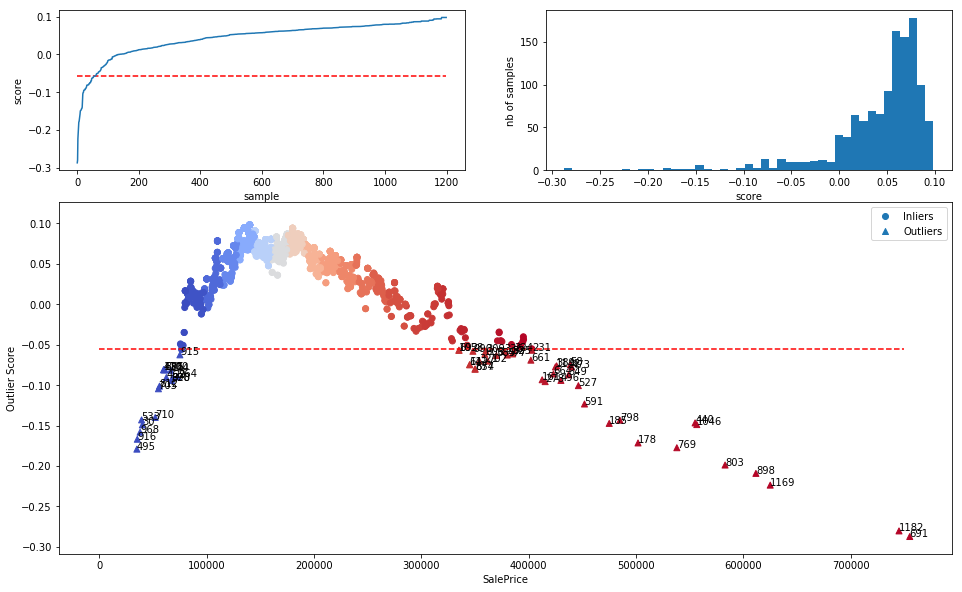

In [28]:
scores_pred, y_pred, threshold, X_inlier, Y_inlier, X_outlier, Y_outlier = findOutliers_IsolationForest(Y.values.reshape(-1,1),X, Y, outliers_fraction)
plotOutliers(scores_pred, y_pred, threshold, X_inlier, Y_inlier, X_outlier, Y_outlier)

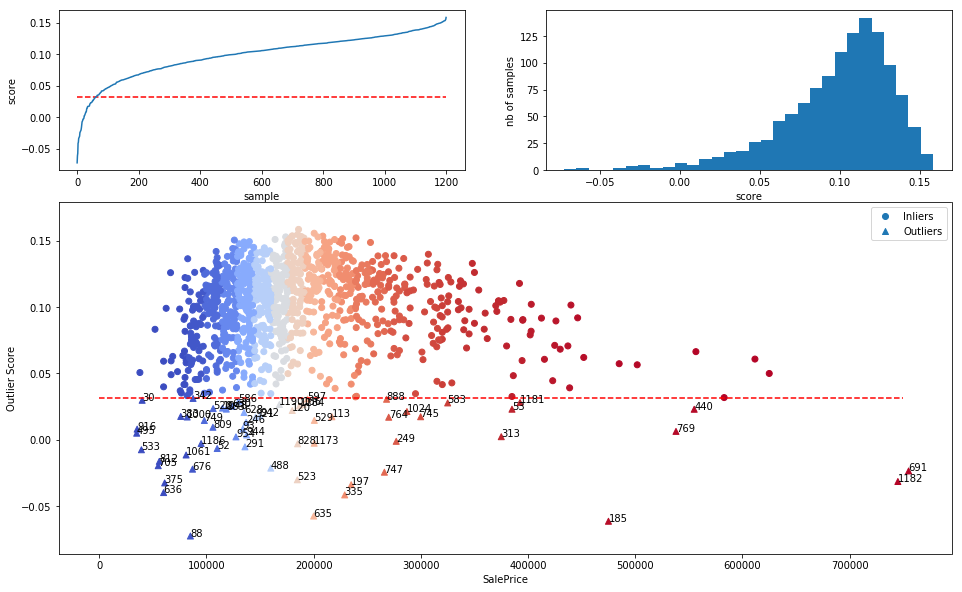

In [29]:
scores_pred, y_pred, threshold, X_inlier, Y_inlier, X_outlier, Y_outlier = findOutliers_IsolationForest(X,X, Y, outliers_fraction)
plotOutliers(scores_pred, y_pred, threshold, X_inlier, Y_inlier, X_outlier, Y_outlier)

## Feature Selection

<div class='alert alert-warning'>
&emsp;After having encoded the categorical feature the dataset contains 79 or 291 features. In both cases, the problem as it is, is a high dimensionality problem. One can wonder wether all features will actually help our model learn and reach higher precision. The greater the dimension, the more chance the model has to overfit the data. It may give too much importance on a certain feature.<br>
&emsp;To do so, several techniques are used, we chose to stay with a tree like technique to stay on the guideline of this notebook.
</div>

In [259]:
l = np.array([1,0])
l[::-1]

array([0, 1])

In [261]:
def featureSelection(nbFeature, X,Y,outliers_detection=False,X_outliers=None,tree=True,forest=False):
    """Trims the input data to have nbFeature at the end with a single tree or forest technique
    sort_index,X_trimmed = featureSelection(nbFeature, X,Y,tree=True,forest=False)
    """
    if tree: clf = DecisionTreeRegressor()
    elif forest: clf = RandomForestRegressor(n_estimators=100)
    else: raise Exception("Choose a feature selection process true=True or forest=True")
    clf = clf.fit(X, Y)
    feature_importances = clf.feature_importances_
    sort_index = np.argsort(feature_importances)[::-1]
    kept_columnValues = list(X.columns.values)
    selected_features = np.array(kept_columnValues)[sort_index[:nbFeature]]
    X_trimmed = X.filter(selected_features,axis=1)
    if outliers_detection: X_outliers_trimmed = X_outliers.filter(selected_features,axis=1)
    else: X_outliers_trimmed=None
    return sort_index[::-1],X_trimmed,X_outliers_trimmed,feature_importances

In [32]:
nbFeature = X.shape[1]
sort_index,X_trimmed,_,feature_importances = featureSelection(nbFeature, X,Y,tree=True,forest=False)
sort_index_forest,X_trimmed,_,feature_importances_forest = featureSelection(nbFeature, X,Y,tree=False,forest=True)


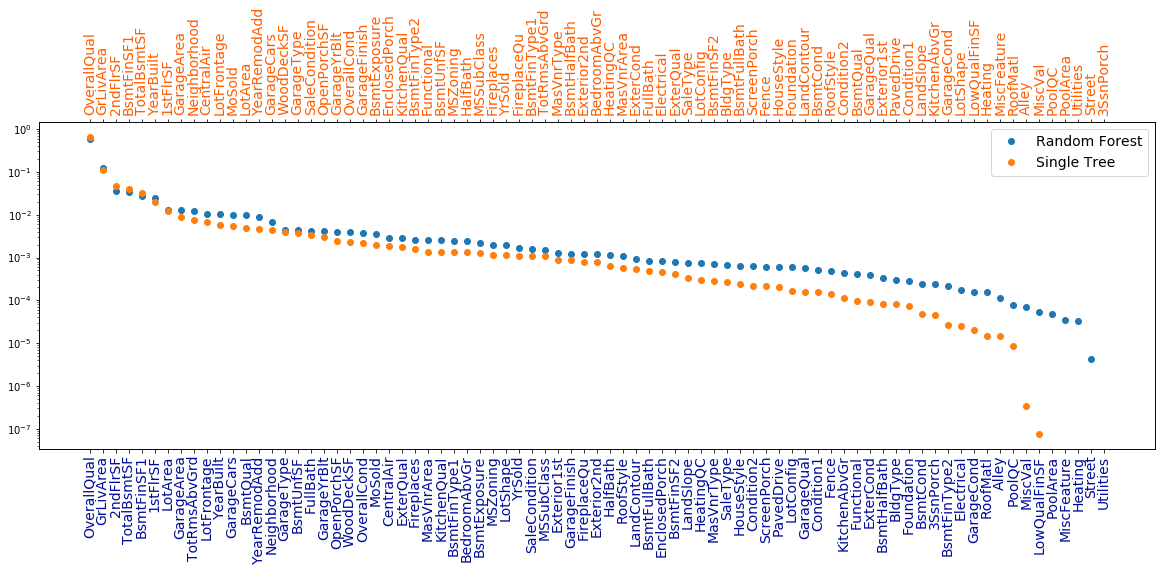

In [33]:
kept_columnValues= list(X.columns.values)
fig, ax =plt.subplots(figsize=(20,6))
ax.semilogy(np.sort(feature_importances_forest)[::-1],'o',label='Random Forest',alpha=1)
locs = ax.set_xticks(np.arange(len(kept_columnValues)))
ax.set_xticklabels(np.array(kept_columnValues)[sort_index_forest][::-1], rotation='vertical',fontsize=14)
[x.set_color('#000c99') for x in ax.get_xticklabels()]

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(np.arange(len(kept_columnValues)))


ax.semilogy(np.sort(feature_importances)[::-1],'o',label='Single Tree',alpha=1)
ax2.set_xticks(np.arange(len(kept_columnValues)))
ax2.set_xticklabels(np.array(kept_columnValues)[sort_index][::-1], rotation='vertical',fontsize=14)
[x.set_color('#ff5d00') for x in ax2.get_xticklabels()]


pylab.ylabel("Feature Importance")
ax.legend(fontsize=14)
plt.show()

## PCA?

In [34]:
def PCA(nbPrincipalComponent,X):
    pca = decomposition.PCA(n_components=nbPrincipalComponent)
    principalComponents = pca.fit_transform(X)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['pc'+str(i+1) for i in range(nbPrincipalComponent)])
    return(principalDf)

In [87]:
nbPrincipalComponent = 2
pca = decomposition.PCA(n_components=nbPrincipalComponent)
principalComponents = pca.fit_transform(X)
principalDf = PCA(nbPrincipalComponent,X_scaled)


[[-2108.22141589    34.66585902]
 [ -955.26794462   -65.36209144]
 [  691.65286326   136.85265142]
 ...
 [-1716.33079455   -28.36570697]
 [-1464.40910633   -33.94811352]
 [  675.98212166   -84.4671255 ]]


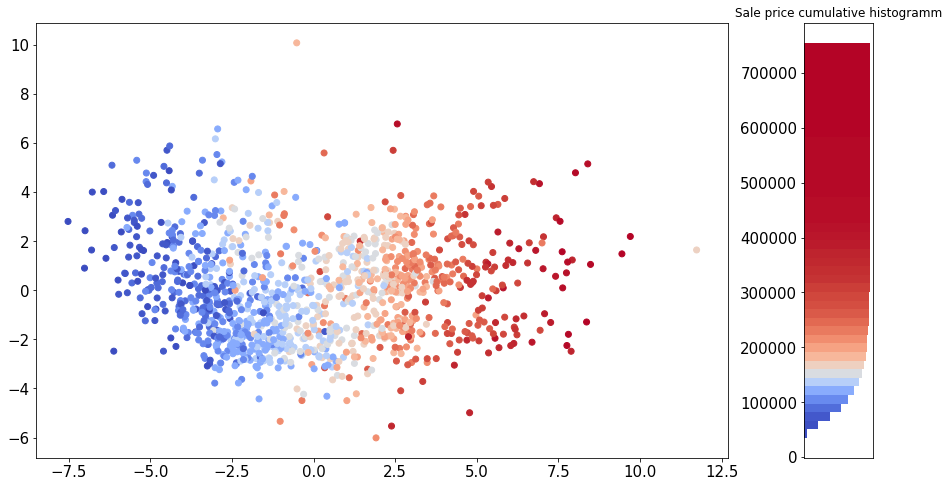

In [36]:
plt.figure(figsize=(15,8))
gs = gridspec.GridSpec(1, 2, width_ratios=[10, 1])
plt.subplot(gs[0])
sc = plt.scatter(principalDf.pc1,principalDf.pc2,c=colors,cmap=cmap)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
#plt.colorbar(sc,ticks=finalDf.SalePrice)
plt.subplot(gs[1])
histbis = plt.hist(Y,cumulative=True,normed=True,bins='auto',orientation='horizontal')
for c, p in zip(histbis[0], histbis[2]):
    plt.setp(p, 'facecolor', cmap(c))
plt.gca().set_xscale("log")
plt.title("Sale price cumulative histogramm")
plt.yticks(fontsize=15)
plt.tick_params(axis='x',which='both',bottom='off',labelbottom='off')
plt.show()

## Building and Training the statistical model

In [37]:
def getLogRMSE(estimatedPrice,realPrice):
    logRMSE = np.mean( (np.log(estimatedPrice) - np.log(realPrice))**2 )
    #logRMSE = sum( (estimatedPrice - realPrice)**2 )
    return np.sqrt(logRMSE)
def regressionTrees(X=X,X_outliers=[],Y_outliers=[],Y=Y,depth=6,min_samples_leaf=8,test_size=0.1,singleTree=True,forest=False,extraTrees=False,nb_estimator=20):
    #X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = test_size, random_state = 42)# np.random.randint(0,100))
    nkfold = int(1/test_size)
    foldNb = 0
    kf = KFold(n_splits=nkfold,random_state=42)
    test_errors = []
    training_errors = []
    X= np.array(X)
    Y=np.array(Y)
    X_outliers = np.array(X_outliers)
    Y_outliers = np.array(Y_outliers)
    if(len(X_outliers)>=nkfold): indexSampleOutliers = zip(kf.split(X),kf.split(X_outliers)) #enough outliers to split them into K fold
    else: indexSampleOutliers = zip(kf.split(X),np.zeros((nkfold,2)))    
    for (train_index, test_index), (outliers_train,outliers_index) in indexSampleOutliers:
        #Reset regressor
        if singleTree: regressor = DecisionTreeRegressor(min_samples_leaf=min_samples_leaf,max_depth=depth)
        elif forest: regressor = RandomForestRegressor(min_samples_leaf=min_samples_leaf,max_depth=depth,n_estimators=nb_estimator,random_state=42)#, max_depth=depth,min_samples_leaf=min_samples_leaf)
        elif extraTrees: regressor = ExtraTreesClassifier(min_samples_leaf=min_samples_leaf,max_depth=depth,n_estimators=nb_estimator,random_state=42)#, max_depth=depth,min_samples_leaf=min_samples_leaf)
        else: raise Exception("Choose a regression model")
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        if(len(X_outliers)>=nkfold):
            X_outliers_test,X_outliers_train = X_outliers[outliers_index],X_outliers[outliers_train] #get a proportinal number of outliers to calculate error
            Y_outliers_test,Y_outliers_train = Y_outliers[outliers_index],Y_outliers[outliers_train]
            X_train = np.concatenate((X_train,X_outliers_train)) #Add the proportion of outliers in the training set
            y_train = np.concatenate((y_train,Y_outliers_train))

        regressor.fit(X_train, y_train)
        y_hat_test = regressor.predict(X_test)
        
        training_estimation = regressor.predict(X_train)
        
        if(len(X_outliers)>=nkfold):
            y_hat_test_outliers = regressor.predict(X_outliers_test)
            y_hat_test = np.concatenate((y_hat_test,y_hat_test_outliers))
            y_test = np.concatenate((y_test,Y_outliers_test))
        
        test_errors.append(getLogRMSE(y_hat_test,y_test))
        training_errors.append(getLogRMSE(training_estimation,y_train))
        
    return np.mean(test_errors),np.mean(training_errors),regressor #test error train error

## Executing the pipeline

In [308]:
def pipeline(pdAllData_Categ, preProcessing=True,encoding_technique='labelEncode', outliers_fraction=0.05, nbFeatures=30, feature_selection_technique='forest', nbPCA=False, regressor='singleTree',  depth=6, min_samples_leaf=8, test_size=0.1, nb_estimator=20):

    if preProcessing: X_scaled = preprocessing(pdAllData_Categ,encoding_technique=encoding_technique)
    else: X_scaled = pdAllData_Categ #Df was preprecessed to avoid costly computations while testing
    
    #Feature Selection
    if nbFeatures>0:
        if feature_selection_technique == 'tree':tree,forest=True,False
        elif feature_selection_technique == 'forest':tree,forest=False,True

        sort_index,X_trimmed,_,_ = featureSelection(nbFeatures, X_scaled, Y, tree=tree, forest=forest)
    elif nbFeatures<0:X_trimmed = X_scaled
    else: raise Exception('Choose at least 1 feature to be selected or put negative numbers to take all features')
    
    #PCA 
    if nbPCA: X_trimmed_pca = PCA(nbPCA,X_trimmed)
    else: X_trimmed_pca = X_trimmed
    #Outliers Detection
    
    scores_pred, y_pred, threshold, X_inliers, Y_inliers, X_outliers, Y_outliers = findOutliers_IsolationForest(X_trimmed_pca,X_trimmed_pca, Y, outliers_fraction)
    
    
   
    #print('After FeatureSelection',X_trimmed.shape)
    #Learning and evaluation
    if regressor == 'singleTree':singleTree,forest,extraTrees = True,False,False
    elif regressor == 'forest':forest,singleTree,extraTrees = True,False,False
    elif regressor == 'extraTrees':extraTrees,singleTree,forest = True,False,False
    else: raise Exception('Chosoe a regressor model among singleTree, forest, extraTrees')
    test_error, training_error,regressor = regressionTrees(X=X_inliers,X_outliers=X_outliers,Y_outliers=Y_outliers,Y=Y_inliers,depth=depth,min_samples_leaf=min_samples_leaf,test_size=test_size,singleTree=singleTree,forest=forest,extraTrees=extraTrees,nb_estimator=nb_estimator)
    
    return test_error, training_error,regressor

In [403]:
encoding_technique='labelEncode'
outliers_fraction=0.05
nbFeatures=50
feature_selection_technique='forest'
regressor = 'forest'
nbPCA = 10
depth=100
min_samples_leaf=8
test_size=0.25
nb_estimator=20
X_scaled = preprocessing(pdAllData_Categ,encoding_technique=encoding_technique)
test_error, training_error,_ = pipeline(X_scaled,preProcessing = False, encoding_technique=encoding_technique, outliers_fraction=outliers_fraction, nbFeatures=nbFeatures, feature_selection_technique=feature_selection_technique, nbPCA=nbPCA, regressor=regressor,  depth=depth, min_samples_leaf=min_samples_leaf, test_size=test_size, nb_estimator=nb_estimator)
print('Test Error =',test_error,' Train error = ',training_error)

ValueError: No objects to concatenate

## Optimising the pipeline

In [298]:
encoding_techniques=['labelEncode','oneHotEncode','persoLabelEncodeOrdered']
regressors = ['singleTree','forest','extraTrees']
outliers_fraction=0.05
nbPCA = False
test_errors = np.zeros((3,3))
training_errors = np.zeros((3,3))
for i,encoding_technique in enumerate(encoding_techniques):
    for j,regressor in enumerate(regressors):
        test_error, training_error,_ = pipeline(pdAllData_Categ, encoding_technique=encoding_technique, outliers_fraction=outliers_fraction, nbFeatures=nbFeatures, feature_selection_technique=feature_selection_technique, nbPCA=nbPCA, regressor=regressor,  depth=depth, min_samples_leaf=min_samples_leaf, test_size=test_size, nb_estimator=nb_estimator)
        test_errors[i,j] = test_error
        training_errors[i,j] = training_error

In [299]:
columns_label =['singleTree','forest','extraTrees']
results = pd.DataFrame(data=test_errors,index=encoding_techniques,columns=columns_label)
results

,singleTree,forest,extraTrees
labelEncode,0.193242,0.160528,0.217598
oneHotEncode,0.184861,0.158507,0.224065
persoLabelEncodeOrdered,0.188278,0.154052,0.215177


#### Number of features selected

In [309]:
outliers_fraction=0.05
feature_selection_technique='forest'
regressor = 'forest'
nbPCA = False
depth=100
min_samples_leaf=8
test_size=0.25
nb_estimator=20
nbFeatures_list = np.arange(2,80,3)
nbFeatures_list_hot = np.arange(2,293,10)
test_errors_labelEncode = []
train_errors_labelEncode = []

test_errors_labelEncodeOrdered = []
train_errors_labelEncodeOrdered = []

test_errors_hotEncode = []
train_errors_hotEncode = []


X_scaled = preprocessing(pdAllData_Categ,encoding_technique='labelEncode')
for nbFeatures in nbFeatures_list:
    print(nbFeatures)
    test_error, training_error,_ = pipeline(X_scaled,preProcessing=False, outliers_fraction=outliers_fraction, nbFeatures=nbFeatures, feature_selection_technique=feature_selection_technique, nbPCA=nbPCA, regressor=regressor,  depth=depth, min_samples_leaf=min_samples_leaf, test_size=test_size, nb_estimator=nb_estimator)
    test_errors_labelEncode.append(test_error)
    train_errors_labelEncode.append(training_error)
    
X_scaled = preprocessing(pdAllData_Categ,encoding_technique='persoLabelEncodeOrdered')
for nbFeatures in nbFeatures_list:
    print(nbFeatures)
    test_error, training_error,_ = pipeline(X_scaled,preProcessing=False, outliers_fraction=outliers_fraction, nbFeatures=nbFeatures, feature_selection_technique=feature_selection_technique, nbPCA=nbPCA, regressor=regressor,  depth=depth, min_samples_leaf=min_samples_leaf, test_size=test_size, nb_estimator=nb_estimator)
    test_errors_labelEncodeOrdered.append(test_error)
    train_errors_labelEncodeOrdered.append(training_error)
    
X_scaled = preprocessing(pdAllData_Categ,encoding_technique='oneHotEncode')
for nbFeatures in nbFeatures_list_hot:
    print(nbFeatures)
    test_error, training_error,_ = pipeline(X_scaled, preProcessing=False, outliers_fraction=outliers_fraction, nbFeatures=nbFeatures, feature_selection_technique=feature_selection_technique, nbPCA=nbPCA, regressor=regressor,  depth=depth, min_samples_leaf=min_samples_leaf, test_size=test_size, nb_estimator=nb_estimator)
    test_errors_hotEncode.append(test_error)
    train_errors_hotEncode.append(training_error)



2
5
8
11
14
17
20
23
26
29
32
35
38
41
44
47
50
53
56
59
62
65
68
71
74
77
2
5
8
11
14
17
20
23
26
29
32
35
38
41
44
47
50
53
56
59
62
65
68
71
74
77
2
12
22
32
42
52
62
72
82
92
102
112
122
132
142
152
162
172
182
192
202
212
222
232
242
252
262
272
282
292


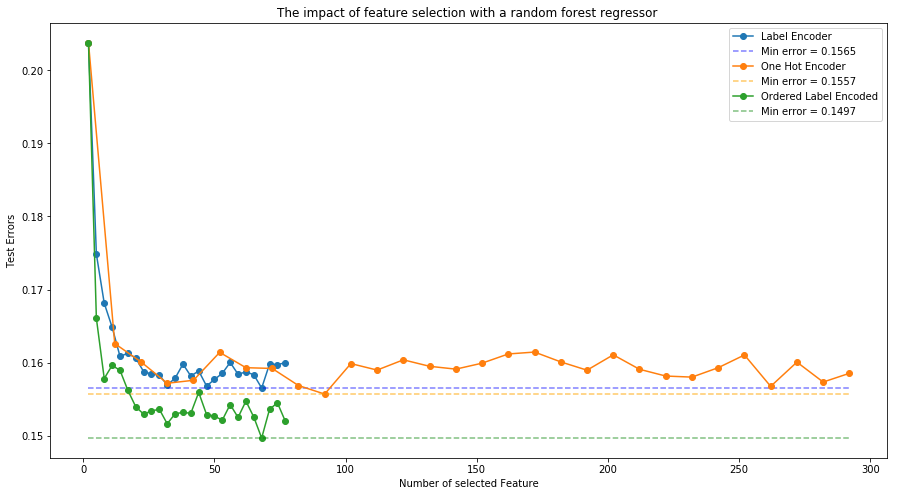

In [328]:
plt.figure(figsize=(15,8))
plt.title('The impact of feature selection with a random forest regressor ')
plt.plot(nbFeatures_list,test_errors_labelEncode,'-o',label='Label Encoder')
plt.plot(nbFeatures_list_hot,[np.min(test_errors_labelEncode)]*len(nbFeatures_list_hot),'--',c='b',alpha=0.5,label='Min error = '+str(np.min(test_errors_labelEncode))[:6])

plt.plot(nbFeatures_list_hot,test_errors_hotEncode,'-o',label='One Hot Encoder')
plt.plot(nbFeatures_list_hot,[np.min(test_errors_hotEncode)]*len(nbFeatures_list_hot),'--',c='orange',alpha=0.6,label='Min error = '+str(np.min(test_errors_hotEncode))[:6])

plt.plot(nbFeatures_list,test_errors_labelEncodeOrdered,'-o',label='Ordered Label Encoded')
plt.plot(nbFeatures_list_hot,[np.min(test_errors_labelEncodeOrdered)]*len(nbFeatures_list_hot),'--',c='g',alpha=0.5,label='Min error = '+str(np.min(test_errors_labelEncodeOrdered))[:6])

plt.ylabel('Test Errors')
plt.xlabel('Number of selected Feature')
plt.legend()
plt.show()

In [330]:
regressor = 'forest'
pca_list = np.arange(1,80,3)
pca_list_hot = np.arange(1,293,10)
nbFeatures = -1
test_errors_labelEncode_pca = []
train_errors_labelEncode_pca = []

test_errors_labelEncodeOrdered_pca = []
train_errors_labelEncodeOrdered_pca = []

test_errors_hotEncode_pca = []
train_errors_hotEncode_pca = []

X_scaled = preprocessing(pdAllData_Categ,encoding_technique='labelEncode')
for nbPCA in pca_list:
    print(nbPCA)
    test_error, training_error,_ = pipeline(X_scaled,preProcessing=False, outliers_fraction=outliers_fraction, nbFeatures=nbFeatures, feature_selection_technique=feature_selection_technique, nbPCA=nbPCA, regressor=regressor,  depth=depth, min_samples_leaf=min_samples_leaf, test_size=test_size, nb_estimator=nb_estimator)
    test_errors_labelEncode_pca.append(test_error)
    train_errors_labelEncode_pca.append(training_error)
    
X_scaled = preprocessing(pdAllData_Categ,encoding_technique='persoLabelEncodeOrdered')
for nbPCA in pca_list:
    print(nbPCA)
    test_error, training_error,_ = pipeline(X_scaled,preProcessing=False, outliers_fraction=outliers_fraction, nbFeatures=nbFeatures, feature_selection_technique=feature_selection_technique, nbPCA=nbPCA, regressor=regressor,  depth=depth, min_samples_leaf=min_samples_leaf, test_size=test_size, nb_estimator=nb_estimator)
    test_errors_labelEncodeOrdered_pca.append(test_error)
    train_errors_labelEncodeOrdered_pca.append(training_error)

X_scaled = preprocessing(pdAllData_Categ,encoding_technique='oneHotEncode')
for nbPCA in pca_list_hot:
    print(nbPCA)
    test_error, training_error,_ = pipeline(X_scaled,preProcessing=False, outliers_fraction=outliers_fraction, nbFeatures=nbFeatures, feature_selection_technique=feature_selection_technique, nbPCA=nbPCA, regressor=regressor,  depth=depth, min_samples_leaf=min_samples_leaf, test_size=test_size, nb_estimator=nb_estimator)
    test_errors_hotEncode_pca.append(test_error)
    train_errors_hotEncode_pca.append(training_error)



1
4
7
10
13
16
19
22
25
28
31
34
37
40
43
46
49
52
55
58
61
64
67
70
73
76
79
1
4
7
10
13
16
19
22
25
28
31
34
37
40
43
46
49
52
55
58
61
64
67
70
73
76
79
1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211
221
231
241
251
261
271
281
291


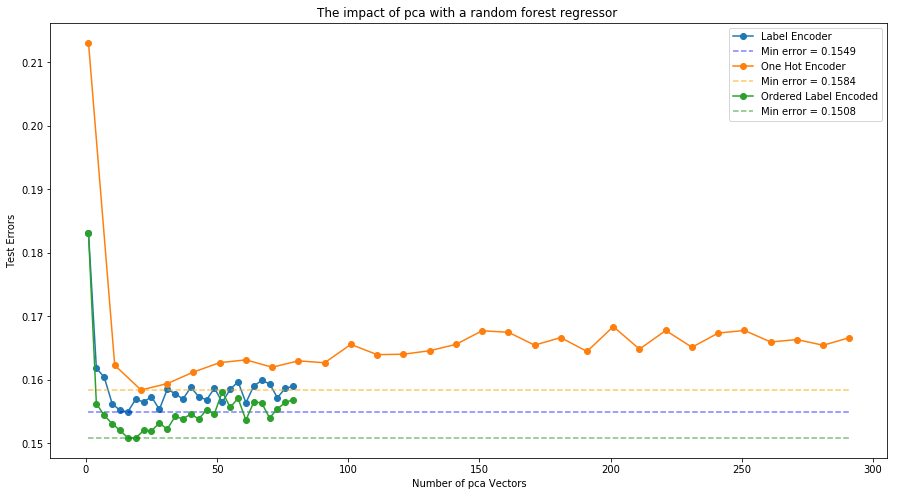

In [335]:
plt.figure(figsize=(15,8))
plt.title('The impact of pca with a random forest regressor ')
#plt.plot(pca_list,test_errors_labelEncode_pca,'-o',label='Label Encoder')
#plt.plot(pca_list_hot,test_errors_hotEncode_pca,'-o',label='One Hot Encoder')
#plt.plot(pca_list_hot,test_errors_labelEncodeOrdered_pca,'-o',label='Ordered Label Encoded')

plt.plot(pca_list,test_errors_labelEncode_pca,'-o',label='Label Encoder')
plt.plot(pca_list_hot,[np.min(test_errors_labelEncode_pca)]*len(pca_list_hot),'--',c='b',alpha=0.5,label='Min error = '+str(np.min(test_errors_labelEncode_pca))[:6])

plt.plot(pca_list_hot,test_errors_hotEncode_pca,'-o',label='One Hot Encoder')
plt.plot(pca_list_hot,[np.min(test_errors_hotEncode_pca)]*len(pca_list_hot),'--',c='orange',alpha=0.6,label='Min error = '+str(np.min(test_errors_hotEncode_pca))[:6])

plt.plot(pca_list,test_errors_labelEncodeOrdered_pca,'-o',label='Ordered Label Encoded')
plt.plot(pca_list_hot,[np.min(test_errors_labelEncodeOrdered_pca)]*len(pca_list_hot),'--',c='g',alpha=0.5,label='Min error = '+str(np.min(test_errors_labelEncodeOrdered_pca))[:6])

plt.ylabel('Test Errors')
plt.xlabel('Number of pca Vectors')
plt.legend()
plt.show()

In [160]:
nbFeatures_list = np.arange(1,80,2)
pca_list = np.arange(1,80,2)
features_grid, pca_grid = np.meshgrid(nbFeatures_list,pca_list)
           

In [164]:
test_error_grid = np.zeros(features_grid.shape)
train_error_grid = np.zeros(features_grid.shape)
for j,nbPCA in enumerate(pca_list):
    for i,nbFeatures in enumerate(nbFeatures_list):            
        if(i<=j): #The PCA is done before the feature selection 
            test_error, training_error,_ = pipeline(pdAllData_Categ, encoding_technique='labelEncode', outliers_fraction=outliers_fraction, nbFeatures=nbFeatures, feature_selection_technique=feature_selection_technique, nbPCA=nbPCA, regressor=regressor,  depth=depth, min_samples_leaf=min_samples_leaf, test_size=test_size, nb_estimator=nb_estimator)
            test_error_grid[i,j] = test_error
            train_error_grid[i,j] = training_error
    print(j,' PCA DONE')

0  PCA DONE
1  PCA DONE
2  PCA DONE
3  PCA DONE
4  PCA DONE
5  PCA DONE
6  PCA DONE
7  PCA DONE
8  PCA DONE
9  PCA DONE
10  PCA DONE
11  PCA DONE
12  PCA DONE
13  PCA DONE
14  PCA DONE
15  PCA DONE
16  PCA DONE
17  PCA DONE
18  PCA DONE
19  PCA DONE
20  PCA DONE
21  PCA DONE
22  PCA DONE
23  PCA DONE
24  PCA DONE
25  PCA DONE
26  PCA DONE
27  PCA DONE
28  PCA DONE
29  PCA DONE
30  PCA DONE
31  PCA DONE
32  PCA DONE
33  PCA DONE
34  PCA DONE
35  PCA DONE
36  PCA DONE
37  PCA DONE
38  PCA DONE
39  PCA DONE


In [165]:
for j,nbPCA in enumerate(pca_list):
    for i,nbFeatures in enumerate(nbFeatures_list):
        if(i>j): #The PCA is done before the featue selection 
            test_error_grid[i,j] = 0.4
            train_error_grid[i,j] = 0.4

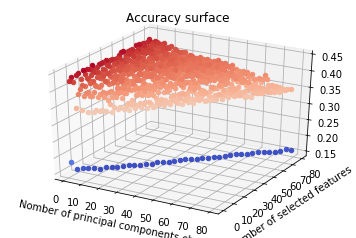

In [168]:
fig = plt.figure()
ax = fig.gca(projection='3d')
max_err = np.max(test_error_grid)
min_err = np.min(test_error_grid)
for j,nbPCA in enumerate(pca_list):
    for i,nbFeatures in enumerate(nbFeatures_list):
        if i<=j:
            color = (test_error_grid[i,j]-min_err)/(max_err-min_err)
            ax.scatter(pca_grid[i,j],features_grid[i,j],test_error_grid[i,j],c = cm.coolwarm(color))
plt.title('Accuracy surface')
plt.ylabel('Nomber of selected features')
plt.xlabel('Nomber of principal components chosen')
plt.show()

In [148]:
min_err

0.15590974846907352

### Grid Search

In [157]:
depth_list = np.arange(1,21)
min_samples_leaf_list = np.arange(1,40)
depth_grid,min_samples_leaf_grid = np.meshgrid(depth_list,min_samples_leaf_list)